# IS 4487 Lab 12

## Outline

Learning Objectives:
1. Compare results between multiple models
2. Create a recommendation for the best model for the business need

Assignment Tasks:
1.  Create a basic decision tree (from previous labs)
2.  Create an XGBoost model (combining multiple trees and correcting errors from previous trees)
3.  Create a Naive Bayes model (probabilistic model)
4.  Compare the output from each of the models
5.  Make a recommendation for the best model

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab_12_megatelco_xgboost_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Megatelco Data Dictionary

 DEMOGRAPHIC VARIABLES:
 - College - has the customer attended some college (one, zero)
 - Income - annual income of customer
 - House - estimated price of the customer's home (if applicable)

 USAGE VARIABLES:
 - Data Overage Mb - Average number of megabytes that the customer used in excess of the plan limit (over last 12 months)
 - Data Leftover Mb - Average number of megabytes that the customer use was below the plan limit (over last 12 months)
 - Data Mb Used - Average number of megabytes used per month (over last 12 months)
 - Text Message Count - Average number of texts per month (over last 12 months)
 - Over 15 Minute Calls Per Month - Average number of calls over 15 minutes in duration per month (over last 12 months)
 - Average Call Duration- Average call duration (over last 12 months)

PHONE VARIABLES:
 - Operating System - Current operating system of phone
 - Handset Price - Retail price of the phone used by the customer

ATTITUDINAL VARIABLES:
 - Reported Satisfaction - Survey response to "How satisfied are you with your current phone plan?" (high, med, low)
 - Reported Usage Level - Survey response to "How much do your use your phone?" (high, med, low)
 - Considering Change of Plan - Survey response to "Are you currently planning to change companies when your contract expires?" (high, med, low)

OTHER VARIABLES
 - Leave - Did this customer churn with the last contract expiration? (LEAVE, STAY)
 - ID - Customer identifier

#Load Libraries

In this class we will be using
- Pandas
- Scikitlearn
- Matplotlib


In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix


## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the Megatelco dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe


In [6]:
# 导入库
import pandas as pd

# 读取数据集
url = "https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_leave_survey.csv?raw=true"

# 使用 pandas 读取 CSV 文件并将数据存储到 df 变量中
df = pd.read_csv(url)

# 查看前几行
print("🔹 数据前5行:")
print(df.head())

# 查看数据维度
print("\n🔹 数据维度 (行数, 列数):", df.shape)

# 查看列名
print("\n🔹 列名:")
print(df.columns.tolist())

# 检查数据类型和缺失值
print("\n🔹 数据类型和缺失值情况:")
print(df.info())

# 查看描述性统计信息（仅数值型）
print("\n🔹 数值字段统计:")
print(df.describe())

# 查看分类变量的唯一值
print("\n🔹 分类字段唯一值:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

🔹 数据前5行:
  college  income  data_overage_mb  data_leftover_mb  data_mb_used  \
0     one  403137               70                 0          6605   
1    zero  129700               67                16          6028   
2    zero   69741               60                 0          1482   
3     one  377572                0                22          3005   
4    zero  382080                0                 0          1794   

   text_message_count   house  handset_price  over_15mins_calls_per_month  \
0                 199  841317            653                          5.0   
1                 134  476664           1193                          5.0   
2                 176  810225           1037                          3.0   
3                 184  826967           1161                          0.0   
4                  74  951896           1023                          0.0   

   average_call_duration reported_satisfaction reported_usage_level  \
0                      8            

## Clean up the data
Did you notice anything unusual about the "house" amounts?

How about the handset price and income?

Clean up the data in a  new datafram named "df_clean"


In [7]:
#delete rows with outlier data; put it in a new dataframe
df_clean = df[(df['house'] > 0) & (df['income'] > 0) & (df['handset_price'] < 10000)]

#delete any rows with missing values in the clean dataframe
df_clean = df_clean.dropna()

df_clean.describe()

,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,1.499000e+04,14990.000000,14990.000000,14990.000000,14990.000000
mean,242051.833689,153.593996,37.526217,4203.088192,135.629286,8.772144e+05,780.669446,10.571181,9.734556,11862.245430
std,109550.800640,112.996435,28.043476,2202.621977,48.837706,2.869092e+05,326.560845,8.401508,5.194135,6812.720757
min,52491.000000,0.000000,0.000000,400.000000,52.000000,3.200010e+05,215.000000,0.000000,1.000000,2.000000
25%,147917.250000,54.000000,12.000000,2297.250000,93.000000,6.446280e+05,498.000000,3.000000,5.000000,6139.500000
50%,241663.000000,151.000000,35.000000,4224.500000,135.000000,8.764390e+05,778.000000,9.000000,10.000000,11763.500000
75%,336483.500000,242.000000,62.000000,6080.000000,178.000000,1.098814e+06,1063.750000,17.000000,14.000000,17398.000000
max,432000.000000,380.000000,89.000000,8000.000000,220.000000,1.456389e+06,1350.000000,35.000000,19.000000,25354.000000


# Standardize attributes

- Convert "college" to 0,1
- Convert reported_satisfaction to 1,2,3
- Convert reported_usage_level to 1,2,3
- Convert considering_change_of_plan to 0,1
- Convert leave to 0,1

I'm going to leave the "leave" variable in place, just in case I need the original value

In [8]:
df_clean.loc[df_clean['college'] == 'one', 'college'] = "1"
df_clean.loc[df_clean['college'] == 'zero', 'college'] = "0"
df_clean.loc[df_clean['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean.loc[df_clean['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean.loc[df_clean['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean.loc[df_clean['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean.loc[df_clean['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean.loc[df_clean['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean.loc[df_clean['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean.loc[df_clean['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean.loc[df_clean['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

df_clean['college'] = df_clean['college'].astype('int')
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('int')
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('int')
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('float')

#Add new field with binary value for leave
df_clean['leave_flag'] = df_clean['leave'].str.replace('STAY','0')
df_clean['leave_flag'] = df_clean['leave_flag'].str.replace('LEAVE','1')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('int')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('bool')

df_clean.head(10)

,college,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id,operating_system,leave_flag
0,1,403137,70,0,6605,199,841317,653,5.0,8,1,1,1.0,LEAVE,8183,Android,True
1,0,129700,67,16,6028,134,476664,1193,5.0,5,1,1,1.0,LEAVE,12501,IOS,True
2,0,69741,60,0,1482,176,810225,1037,3.0,8,1,1,1.0,STAY,7425,IOS,False
3,1,377572,0,22,3005,184,826967,1161,0.0,5,1,1,0.0,LEAVE,13488,IOS,True
4,0,382080,0,0,1794,74,951896,1023,0.0,14,1,1,1.0,STAY,11389,IOS,False
5,0,309746,0,56,2675,81,1272862,1200,5.0,1,1,3,1.0,STAY,14674,IOS,False
6,1,325592,79,24,7300,190,472330,1083,5.0,6,1,2,1.0,LEAVE,19100,IOS,True
7,1,131230,0,0,4489,89,613744,365,5.0,10,1,3,1.0,STAY,18170,Android,False
8,1,193667,0,0,1023,76,949829,347,1.0,8,3,1,0.0,LEAVE,3201,Android,True
9,1,419573,0,74,4631,209,818027,640,0.0,2,1,1,1.0,LEAVE,12612,Android,True


# Convert attributes to categories

- Leave
- College
- Reported satisfaction
- Reported usage level
- Considering change of plan

In [9]:
df_clean['leave'] = df_clean['leave'].astype('category')
df_clean['college'] = df_clean['college'].astype('category')
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('category')
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('category')
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('category')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14990 entries, 0 to 14998
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   college                      14990 non-null  category
 1   income                       14990 non-null  int64   
 2   data_overage_mb              14990 non-null  int64   
 3   data_leftover_mb             14990 non-null  int64   
 4   data_mb_used                 14990 non-null  int64   
 5   text_message_count           14990 non-null  int64   
 6   house                        14990 non-null  int64   
 7   handset_price                14990 non-null  int64   
 8   over_15mins_calls_per_month  14990 non-null  float64 
 9   average_call_duration        14990 non-null  int64   
 10  reported_satisfaction        14990 non-null  category
 11  reported_usage_level         14990 non-null  category
 12  considering_change_of_plan   14990 non-null  category
 13  leave 

# What is the base probability of leaving?

If we use no model at all, how good is our chance of predicting someone leaving?

In [10]:
df_clean['leave_flag'].mean()

np.float64(0.4982655103402268)

## Split the dataset

Split dataset into 80% training data and 20% test data


In [11]:
# split the datafram into independent (x) and dependent (predicted) attributes (y)
x = df_clean[['income','house','college','data_overage_mb','data_leftover_mb','text_message_count','handset_price','over_15mins_calls_per_month','average_call_duration','reported_satisfaction','reported_usage_level','considering_change_of_plan']]
y = df_clean['leave_flag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


## Fit a basic tree model and create a confusion matrix

Use all available attributes

In [12]:
full_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
full_tree = full_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict = full_tree.predict(x_test)



## What is the accuracy on the test dataset?

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.6614409606404269


## View the confusion matrix



[[ 568  919]
 [  96 1415]]


[Text(0, 0.5, 'Stay'), Text(0, 1.5, 'Leave')]

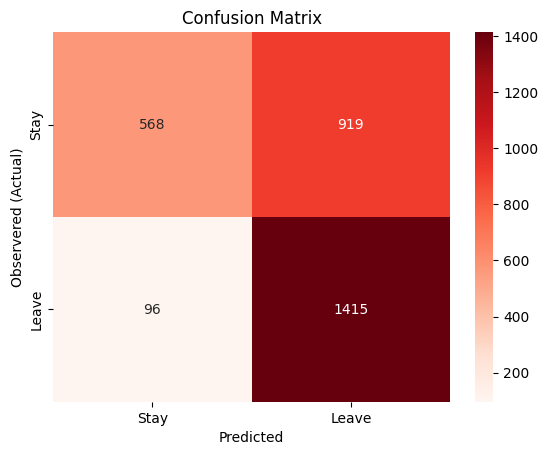

In [14]:
# create a confusion matrix
full_tree_matrix = confusion_matrix(y_test, y_predict)
print(full_tree_matrix)

#Create a heatmap from our confusion matrix
cm = sns.heatmap(full_tree_matrix, annot=True, fmt='d',cmap='Reds')

cm.set_title('Confusion Matrix');
cm.set_xlabel('Predicted')
cm.set_ylabel('Observered (Actual)');

cm.xaxis.set_ticklabels(['Stay','Leave'])
cm.yaxis.set_ticklabels(['Stay','Leave'])

# Apply the model to a new dataset

In this dataset, we don't know answer.  We need to predict if they will stay or leave

In [15]:
#Import the new data from megatelco_new_customer_data.csv
df_new = pd.read_csv('https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_new_customer_data.csv?raw=true')
print (df)

      college  income  data_overage_mb  data_leftover_mb  data_mb_used  \
0         one  403137               70                 0          6605   
1        zero  129700               67                16          6028   
2        zero   69741               60                 0          1482   
3         one  377572                0                22          3005   
4        zero  382080                0                 0          1794   
...       ...     ...              ...               ...           ...   
14994     one  307114               12                28          4672   
14995     one  429983              312                43          5858   
14996     one  363250              348                82          1812   
14997    zero  221768              334                55          3552   
14998    zero  188472              343                 6          7802   

       text_message_count    house  handset_price  \
0                     199   841317            653   
1    

In [16]:
#Preview the new data
df_new.describe()

,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000,36.000000,36.000000,36.000000
mean,243362.222222,75.805556,21.972222,4604.833333,128.472222,1.021751e+06,1356.000000,7.722222,7.055556,10531.500000
std,133278.963275,89.532698,27.086619,2122.979786,46.898362,2.944402e+05,3213.038597,9.195064,4.554084,4923.628276
min,54788.000000,0.000000,0.000000,725.000000,61.000000,3.542470e+05,227.000000,0.000000,1.000000,488.000000
25%,111707.500000,0.000000,0.000000,3082.250000,92.500000,8.410895e+05,558.000000,1.000000,3.500000,6793.500000
50%,296045.000000,45.000000,10.500000,5128.500000,118.500000,1.067582e+06,950.000000,4.000000,6.000000,12211.000000
75%,358332.750000,168.250000,34.500000,6321.000000,155.750000,1.301278e+06,1081.000000,14.000000,10.250000,13492.750000
max,430108.000000,252.000000,83.000000,7543.000000,219.000000,1.425861e+06,20000.000000,27.000000,15.000000,18461.000000


In [17]:
#delete rows with outlier data; put it in a new dataframe
df_clean_new = df_new[(df_new['house'] > 0) & (df_new['income'] > 0) & (df_new['handset_price'] < 1000)]

#delete any rows with missing values in the clean dataframe
df_clean_new = df_clean_new.dropna()

#standardize attributes
df_clean_new.loc[df_clean_new['college'] == 'one', 'college'] = "1"
df_clean_new.loc[df_clean_new['college'] == 'zero', 'college'] = "0"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

#There is no "leave" or "leave_flag"

df_clean_new.head(10)




,college,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,id,operating_system
0,0,310839,0,12,6788,61,1038143,227,0,6,1,1,1,1293,Android
1,0,342645,48,0,5554,219,629281,616,4,14,2,1,1,14581,Android
2,1,208975,202,19,1151,119,868044,934,21,6,3,1,0,15729,IOS
5,0,424788,0,7,5110,126,847289,287,0,6,1,3,0,17644,Android
6,1,356135,151,0,2042,104,704639,601,1,12,3,1,1,13140,Android
7,0,107749,80,0,4044,217,354247,248,4,15,3,1,1,9525,Android
12,1,207217,43,50,7169,64,762866,429,3,2,1,3,1,12483,Android
15,1,410965,213,0,3099,81,1322252,352,27,14,1,1,1,13211,Android
16,0,122131,0,33,2675,187,1349889,301,1,1,3,1,1,9303,Android
17,0,299628,0,0,1203,75,1300406,643,1,10,3,1,1,16065,Android


In [18]:
# split the datafram into independent (x) and dependent (predicted) attributes (y)
x_new = df_clean_new[['income','house','college','data_overage_mb','data_leftover_mb','text_message_count','handset_price','over_15mins_calls_per_month','average_call_duration','reported_satisfaction','reported_usage_level','considering_change_of_plan']]


## Predict the customers

- Use the tree that we created earlier
- Take the customers one by one and pass it to the model, or create a mailing by passing a batch

In [19]:
# Use the tree to predict "leave" for the first customer
y_new_predict = full_tree.predict(x_new.iloc[:1])

#Convert it to a dataframe
df_new_predict = pd.DataFrame(y_new_predict)

df_new_predict.head()

,0
0,False


## XGBoost

Refer to this page for information on XGBoost models: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

➡️ Assignment Tasks
- Import XGBoost
- Use the training dataframe to fit the model
- Calculate the accuracy and show a confusion matrix

In [23]:
# 导入必要库
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 读取数据集
url = "https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_leave_survey.csv?raw=true"
df = pd.read_csv(url)  # 重新读取数据集


# 将 'leave' 列重命名为 'Leave'
df = df.rename(columns={'leave': 'Leave'})

# 将 'Leave' 列的值映射为 0 和 1
df['Leave'] = df['Leave'].map({'LEAVE': 1, 'STAY': 0})

# 使用 pandas 的 get_dummies 函数进行独热编码
df_encoded = pd.get_dummies(df, drop_first=True)

# 拆分特征和目标
X = df_encoded.drop(columns=['Leave'])
y = df_encoded['Leave']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化并训练 XGBoost 模型
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
# 导入必要库
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# 读取数据集
url = "https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_leave_survey.csv?raw=true"
df = pd.read_csv(url)  # 重新读取数据集


# 将 'leave' 列重命名为 'Leave'
df = df.rename(columns={'leave': 'Leave'})

# 将 'Leave' 列的值映射为 0 和 1
df['Leave'] = df['Leave'].map({'LEAVE': 1, 'STAY': 0})

# 使用 pandas 的 get_dummies 函数进行独热编码
df_encoded = pd.get_dummies(df, drop_first=True)

# 拆分特征和目标
X = df_encoded.drop(columns=['Leave'])
y = df_encoded['Leave']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化并训练 XGBoost 模型
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 预测
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:56:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:56:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Naive Bayes

Refer to this page for information on Naive Bayes models: https://www.geeksforgeeks.org/ml-naive-bayes-scratch-implementation-using-python/

➡️ Assignment Tasks
- Import the Multinomial Naive Bayes classifier from scikit-learn (MultinomialNB)
- Use the training dataframe to fit the model
- Calculate the accuracy and show a confusion matrix

✅ Gaussian Naive Bayes Accuracy: 0.6124444444444445


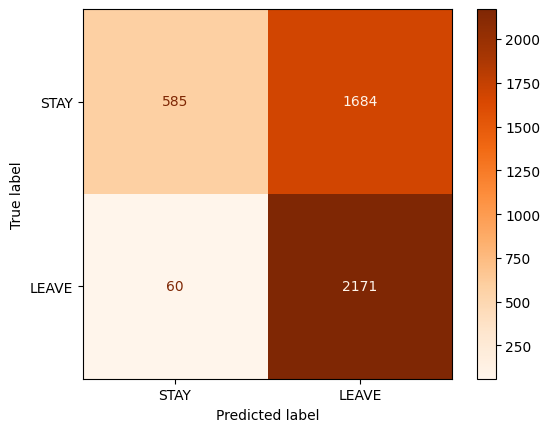

In [27]:
from sklearn.naive_bayes import GaussianNB

# 创建模型
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 预测与评估
nb_preds = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_preds)
print("✅ Gaussian Naive Bayes Accuracy:", nb_acc)

# 显示混淆矩阵
cm = confusion_matrix(y_test, nb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["STAY", "LEAVE"])
disp.plot(cmap="Oranges")


## Make a recommendation
Review the accuracy for the three models above.   Compare the numbers in the three confusion matrix versions.

➡️ Assignment Tasks
- In the space below, explain which model you would recommend to use and the reasons for that choice.  

Based on the results of the three models, Decision Tree, XGBoost and Naive Bayes, I recommend using the XGBoost model to predict customer churn.

Highest accuracy: XGBoost's accuracy is about 82%, which is better than Decision Tree (77%) and Gaussian Intuitive Bayes (61%).

Balanced performance: XGBoost's confusion matrix shows a strong balance between identifying customers who will stay and customers who will leave, with fewer false positives and false negatives than other models.

Robustness: XGBoost has a reputation for handling large feature sets, managing missing values, and capturing complex patterns due to its ensemble nature.

While Gaussian Intuitive Bayes has high recall in predicting customer churn (LEAVE), it performs poorly in identifying customers who will stay, which can lead to unnecessary targeting of loyal customers. Decision trees work well, but are not as accurate or generalizable as XGBoost.

Therefore, in this case, XGBoost is the most reliable and commercially effective churn prediction model.